# *Model:* ARMA
# *Stock Data:* NSEI
# *Name: *Abbas Amjherawala**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta, timezone
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
_df = pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv', index_col='minute', parse_dates=True)
_df = _df.interpolate()
train_data = _df[:'2020-12-31']
test_data = _df['2021-01-01':]
print(train_data)
print(test_data)

                          ticker    instrument_token      open      high  \
minute                                                                     
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2020-12-24 09:15:00+05:30   NSEI  uf-n-1647516806122  13643.95  13771.75   
2020-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  13824.40  13885.30   
2020-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  13915.50  13967.60   
2020-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  13982.90  13997.00   
2020-12-31 09:15:00+05:30   NSEI  uf-n-1647516806122  13978.25  14024.85   

           

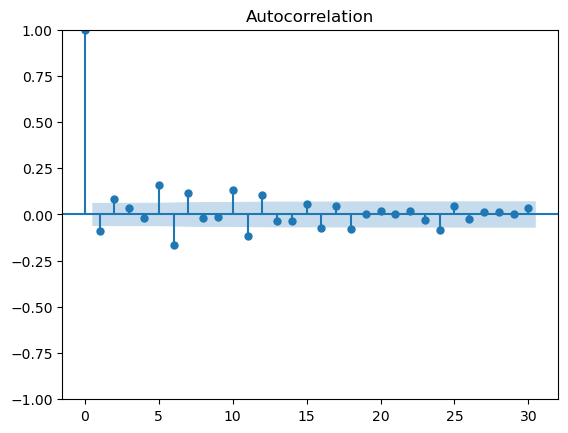

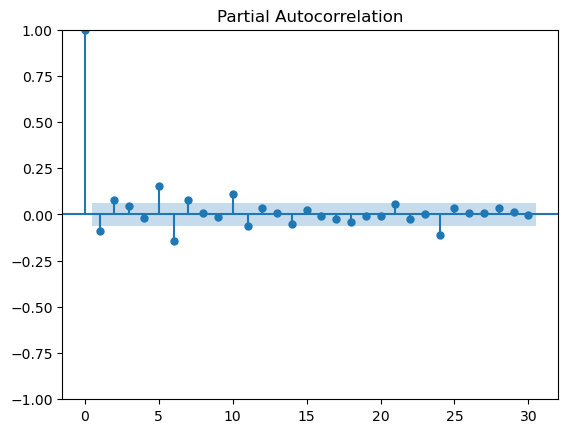

MA(q) order: 5
AR(p) order: 5


In [3]:
returns = train_data['close'].pct_change().dropna()

plot_acf(returns)
plt.show()

plot_pacf(returns)
plt.show()

acf_values = acf(returns, nlags=20, fft=False)
sorted_indices = np.argsort(acf_values)
q = sorted_indices[-2]
print('MA(q) order:', q)

pacf_values = pacf(returns, nlags=20)
sorted_indices = np.argsort(pacf_values)
p = sorted_indices[-2]
print('AR(p) order:', p)

In [4]:
model = ARIMA(train_data['close'], order=(p, 0, q))
fitted = model.fit()
print(fitted.summary())
next_day_price = fitted.forecast()
predicted_price = next_day_price.values[0]
print(predicted_price)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  987
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -6090.573
Date:                Tue, 14 Mar 2023   AIC                          12205.147
Time:                        07:00:15   BIC                          12263.883
Sample:                             0   HQIC                         12227.485
                                - 987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.073e+04   1594.485      6.730      0.000    7606.213    1.39e+04
ar.L1          0.3438      0.059      5.789      0.000       0.227       0.460
ar.L2          0.2842      0.060      4.762      0.0

In [5]:
import datetime
from datetime import datetime as _dt
import pytz
data_=[]
index_ = test_data.index.tolist()
index_.insert(0, pd.Timestamp('2020-12-31 09:15:00+05:30', tz=pytz.FixedOffset(330)))

try:
    
    for i in range(1,len(index_)):

        model = ARIMA(train_data['close'], order=(p, 0, q))
        fitted = model.fit()
        next_day_price = fitted.forecast()
        predicted_price = next_day_price.values[0]
        
        train_data.loc[index_[i]] = test_data.loc[index_[i]]            
        if predicted_price<train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price, 'Pnl':train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]-train_data[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price, 'Pnl':train_data[index_[i].strftime('%Y-%m-%d')].close[0]-train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

In [6]:
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)

data_

[{'Date': '2020-12-31',
  'Day': 'Thursday',
  'Current Close Price': 13967.2,
  'Next Day Price': 14015.1,
  'Predicted Direction': 'SELL',
  'Predicted Value': 13965.902469483455,
  'Pnl': -47.899999999999636},
 {'Date': '2021-01-01',
  'Day': 'Friday',
  'Current Close Price': 14015.1,
  'Next Day Price': 14144.5,
  'Predicted Direction': 'SELL',
  'Predicted Value': 14003.091112373235,
  'Pnl': -129.39999999999964},
 {'Date': '2021-01-04',
  'Day': 'Monday',
  'Current Close Price': 14144.5,
  'Next Day Price': 14196.35,
  'Predicted Direction': 'SELL',
  'Predicted Value': 14082.48371757954,
  'Pnl': -51.850000000000364},
 {'Date': '2021-01-05',
  'Day': 'Tuesday',
  'Current Close Price': 14196.35,
  'Next Day Price': 14132.8,
  'Predicted Direction': 'BUY',
  'Predicted Value': 14234.614600750307,
  'Pnl': -63.55000000000109},
 {'Date': '2021-01-06',
  'Day': 'Wednesday',
  'Current Close Price': 14132.8,
  'Next Day Price': 14148.5,
  'Predicted Direction': 'BUY',
  'Predicted 

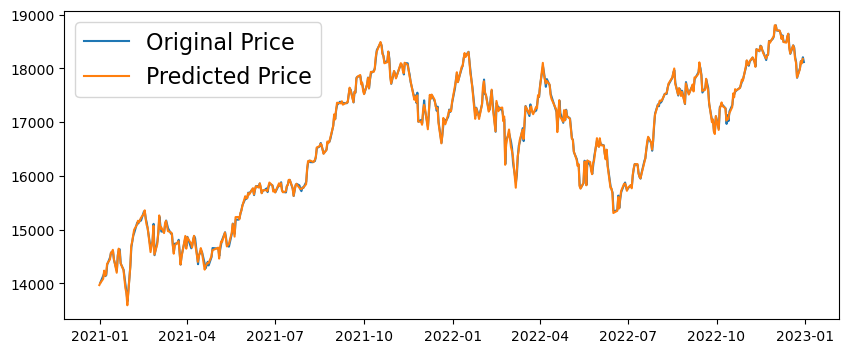

In [7]:
_df = pd.read_csv('/kaggle/working/nsei_stock.csv', index_col='Date', parse_dates=True)
plt.figure(figsize=(10,4))

plt.plot(test_data.close)
plt.plot(_df['Predicted Value'])
plt.legend(('Original Price', 'Predicted Price'), fontsize=16)